# CNN Cancer Detection Kaggle Mini-Project
## Introduction
The aim of this project is to identify metastatic cancer in small image patches taken from larger digital pathology scans using Convolutional Neural Networks (CNN). We will implement CNN using Keras library and perform exploratory data analysis, prepare our data, build models and evaluate our models.


## Data Source
Data source is Histopathologic Cancer Detection kaggle competition and is available at https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

In this dataset we are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder (cancerous or not). We are predicting the labels for the images in the test folder.


## Importing Libraries
We will start by importing the necessary libraries:

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob 

from PIL import Image

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import layers,optimizers,models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

from keras.metrics import AUC

from warnings import filterwarnings
filterwarnings(action='ignore')

## Exploratory Data Analysis
First we will load the training lables data and check the shape. 

**Data size:** There are 220025 rows in the train_labels.csv file.

In [16]:
labels = pd.read_csv('train_labels.csv')
labels.shape

(220025, 2)

Let's check the first few rows to see what the data looks like, id is the image id and label indicates cancerous (1) or non-cancerous (0).

In [17]:
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [18]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


There are no null values and data is already clean.

Here we can see the distribution of the labels in our training data:

label
0    130908
1     89117
Name: count, dtype: int64


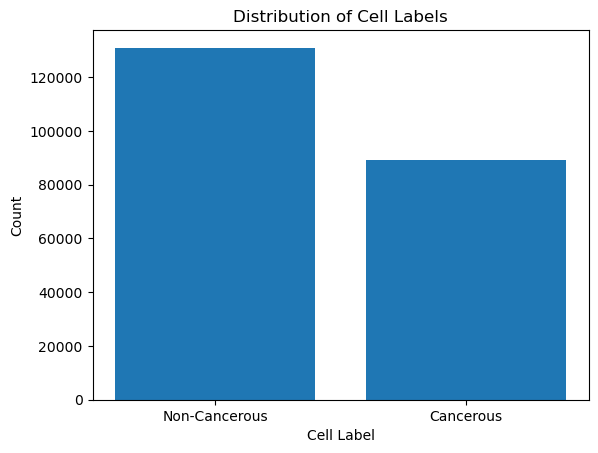

In [19]:
label_counts = labels['label'].value_counts()
print(label_counts)
plt.figure()
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Cell Label')
plt.ylabel('Count')
plt.title('Distribution of Cell Labels')
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])
plt.show()

Here are some example images from our training data:

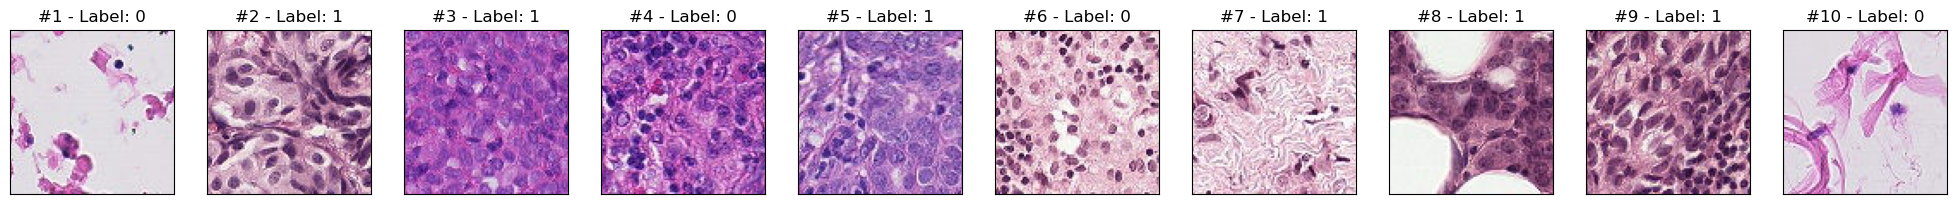

In [20]:
img_train = os.listdir('train/')
img_test = os.listdir('test/')
fig = plt.figure(figsize=(25, 4))
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    im = Image.open('train/' + img_train[i])
    plt.imshow(im)
    label = labels.loc[labels['id'] == img_train[i].split('.')[0], 'label'].values[0]
    ax.set_title(f'#{i+1} - Label: {label}')


## Data Prep
Data set is already clean with no missing values. 
However we will add .tif to the id's and convert labels to str type to prepare for modeling.

In [21]:
labels['id'] += '.tif'
labels['label'] = labels['label'].astype(str)

In [22]:
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


Next we will create a data frame for test data with all the file names in test directory. There are 57458 test images in the test directory.

In [23]:
# dataframe for test 
test = pd.DataFrame({'id':os.listdir('test')})

print(test.shape)

(57458, 1)


In [24]:
test.head()

,id
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif
2,19709bec800f372d0b1d085da6933dd3ef108846.tif
3,7a34fc34523063f13f0617f7518a0330f6187bd3.tif
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif


## Modeling
We will try two models both using Keras library. For both of our models we will follow the recommended architecture from lecture slides CNN_Part2.pdf slide no 32. For the first model we will try optimization method RMSProp. For the second model we will try Adam. 
For both models:
* [Conv-Conv-MaxPool]n structure
* 3x3 filters
* ReLU for hidden layers
* Sigmoid for output layer
* Dropouts
* Batch normalization

### Normalizing and train validation split
We will normalize the training data by dividing each pixel by 255 which will result in values between 0 and 1. 

We will set aside %20 of data for validation. 

In [25]:
im_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

### Generate training data
We have 176020 training data samples.

In [26]:
train_generator = im_datagen.flow_from_dataframe(
    dataframe = labels,
    directory = 'train',
    subset = "training",
    x_col = 'id',
    y_col = 'label',
    target_size = (64,64),
    batch_size = 128 ,
    class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.


### Generate validation data
We have 44005 validation samples

In [27]:
valid_generator = im_datagen.flow_from_dataframe(
    dataframe = labels,
    directory = 'train',
    subset = "validation",
    x_col = 'id',
    y_col = 'label',
    target_size = (64,64),
    batch_size = 128,
    class_mode = 'binary'
)

Found 44005 validated image filenames belonging to 2 classes.


## First Model with RMS Optimization
Our first sequential model has following architecture:

* [Conv-Conv-MaxPool]x2 3x3 filters with ReLU
* Dropout
* Batch Normalization
* [Conv-Conv-AveragePool]x2 3x3 filters with ReLU
* Dropout
* Batch Normalization
* [Conv-Conv-MaxPool]x2 3x3 filters with ReLU
* Batch Normalization
* sigmoid activation for output 
* RMSProp optimization


In [28]:
model_rms = Sequential()
    
model_rms.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(64,64,3)))
model_rms.add(layers.Conv2D(16, (3,3), activation='relu'))
model_rms.add(layers.MaxPooling2D(pool_size=(2,2)))
model_rms.add(Dropout(0.1)) 
model_rms.add(layers.BatchNormalization())

model_rms.add(layers.Conv2D(32, (3,3), activation='relu'))
model_rms.add(layers.Conv2D(32, (3,3), activation='relu'))
model_rms.add(layers.AveragePooling2D(pool_size=(2,2)))
model_rms.add(Dropout(0.1)) 
model_rms.add(layers.BatchNormalization())

model_rms.add(layers.Conv2D(32, (3,3), activation='relu'))
model_rms.add(layers.Conv2D(32, (3,3), activation='relu'))
model_rms.add(layers.MaxPooling2D(pool_size=(2,2)))
model_rms.add(layers.BatchNormalization())

model_rms.add(layers.Flatten())

# Classification layer
model_rms.add(layers.Dense(1, activation='sigmoid'))



In [29]:

model_rms.compile(
    optimizer = 'RMSprop',
    loss = 'binary_crossentropy',
    metrics = ['accuracy', AUC()]
)

rms_history = model_rms.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 6
)


Epoch 1/6
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 154s 111ms/step - accuracy: 0.8061 - auc_1: 0.8747 - loss: 0.4338 - val_accuracy: 0.7887 - val_auc_1: 0.8587 - val_loss: 0.5041
Epoch 2/6
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 155s 113ms/step - accuracy: 0.8501 - auc_1: 0.9216 - loss: 0.3475 - val_accuracy: 0.7835 - val_auc_1: 0.9175 - val_loss: 0.5222
Epoch 3/6
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 154s 112ms/step - accuracy: 0.8682 - auc_1: 0.9364 - loss: 0.3132 - val_accuracy: 0.8597 - val_auc_1: 0.9285 - val_loss: 0.3608
Epoch 4/6
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 153s 111ms/step - accuracy: 0.8767 - auc_1: 0.9442 - loss: 0.2937 - val_accuracy: 0.8504 - val_auc_1: 0.9256 - val_loss: 0.3520
Epoch 5/6
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 152s 110ms/step - accuracy: 0.8870 - auc_1: 0.9514 - loss: 0.2740 - val_accuracy: 0.8352 - val_auc_1: 0.9123 - val_loss: 0.3970
Epoch 6/6
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 153s 111ms/step - accuracy: 0.8936 - auc_1: 0.9554 - loss: 0.2622 - val_accuracy: 0.7820 - val_auc_1: 0.9158 - val

Let's take a look at accuracy, auc and loss of our model with regards to our training and validation data sets:

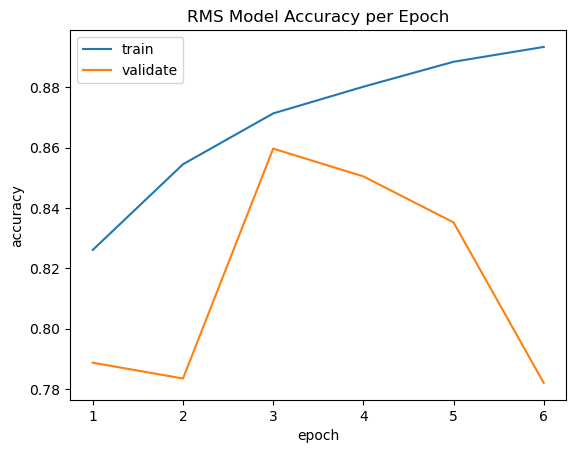

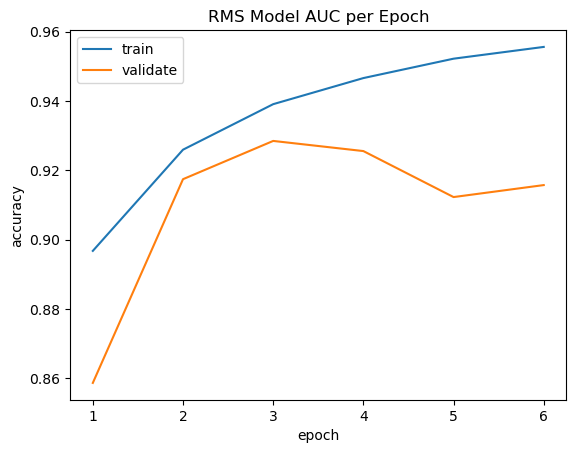

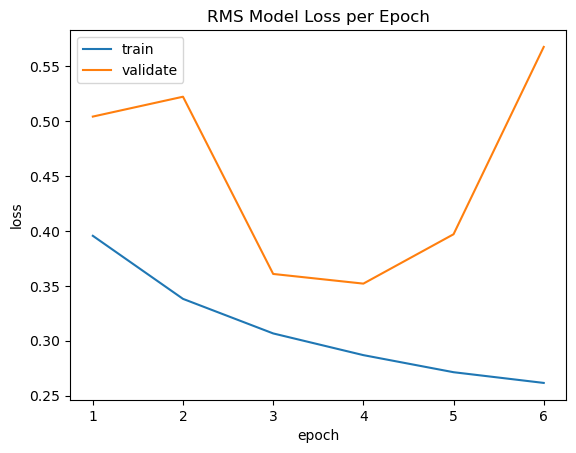

In [33]:
## accuracy plot
plt.plot(np.arange(1,len(rms_history.history['accuracy']) + 1), rms_history.history['accuracy'])
plt.plot(np.arange(1,len(rms_history.history['val_accuracy']) + 1), rms_history.history['val_accuracy'])
plt.title('RMS Model Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# auc plot
plt.plot(np.arange(1,len(rms_history.history['auc_1']) + 1), rms_history.history['auc_1'])
plt.plot(np.arange(1,len(rms_history.history['val_auc_1']) + 1), rms_history.history['val_auc_1'])
plt.title('RMS Model AUC per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(np.arange(1,len(rms_history.history['loss']) + 1), rms_history.history['loss'])
plt.plot(np.arange(1,len(rms_history.history['val_loss']) + 1), rms_history.history['val_loss'])
plt.title('RMS Model Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();


Our first model performance on validation set is poor and haphazard.

## Second Model with Adam Optimization
For our second model we have similar architecture but we will try adam optimization. We will also set learning rate to 0.0001.

In [35]:
## need to update
model_adam = Sequential()
model_adam.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', ))
model_adam.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model_adam.add(MaxPooling2D(pool_size=(2,2)))
model_adam.add(Dropout(0.1))
model_adam.add(BatchNormalization())

model_adam.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_adam.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_adam.add(AveragePooling2D(pool_size=(2,2)))
model_adam.add(Dropout(0.1))    
model_adam.add(BatchNormalization())

model_adam.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_adam.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_adam.add(MaxPooling2D(pool_size=(2,2)))
model_adam.add(BatchNormalization())
               
model_adam.add(Flatten())
model_adam.add(Dense(1, activation='sigmoid'))
    
#build model by input size
model_adam.build(input_shape=(128, 64, 64, 3))       # original image = (96, 96, 3) 
    
#compile
adam_optimizer = Adam(learning_rate=0.0001)
model_adam.compile(loss='binary_crossentropy', metrics=['accuracy', AUC()], optimizer=adam_optimizer)

#quick look at model
model_adam.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (128, 62, 62, 16)      │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (128, 60, 60, 16)      │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (128, 30, 30, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (128, 30, 30, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (128, 30, 30, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (128, 28, 28, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (128, 26, 26, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (128, 13, 13, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (128, 13, 13, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (128, 13, 13, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (128, 11, 11, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (128, 9, 9, 32)        │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (128, 4, 4, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (128, 4, 4, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (128, 512)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (128, 1)               │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,985 (140.57 KB)

 Trainable params: 35,825 (139.94 KB)

 Non-trainable params: 160 (640.00 B)

In [36]:
history_adam = model_adam.fit(
                        train_generator,
                        epochs = 6,
                        validation_data = valid_generator)


Epoch 1/6
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 151s 109ms/step - accuracy: 0.7354 - auc_2: 0.8041 - loss: 0.5501 - val_accuracy: 0.7027 - val_auc_2: 0.8594 - val_loss: 0.7680
Epoch 2/6
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 152s 110ms/step - accuracy: 0.8133 - auc_2: 0.8809 - loss: 0.4219 - val_accuracy: 0.8299 - val_auc_2: 0.9035 - val_loss: 0.3995
Epoch 3/6
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 154s 111ms/step - accuracy: 0.8310 - auc_2: 0.9023 - loss: 0.3860 - val_accuracy: 0.7960 - val_auc_2: 0.9077 - val_loss: 0.4920
Epoch 4/6
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 150s 109ms/step - accuracy: 0.8412 - auc_2: 0.9139 - loss: 0.3648 - val_accuracy: 0.8414 - val_auc_2: 0.9205 - val_loss: 0.3649
Epoch 5/6
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 153s 111ms/step - accuracy: 0.8517 - auc_2: 0.9237 - loss: 0.3433 - val_accuracy: 0.8588 - val_auc_2: 0.9343 - val_loss: 0.3340
Epoch 6/6
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 151s 110ms/step - accuracy: 0.8618 - auc_2: 0.9311 - loss: 0.3263 - val_accuracy: 0.8614 - val_auc_2: 0.9338 - val

Let's take a look at our second model's accuracy, auc and loss with respect to training and validation data:

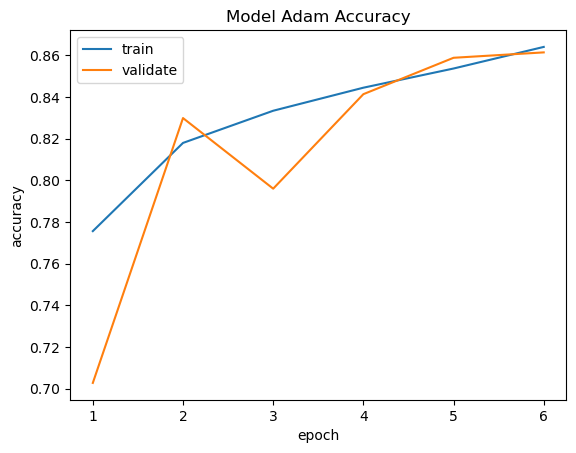

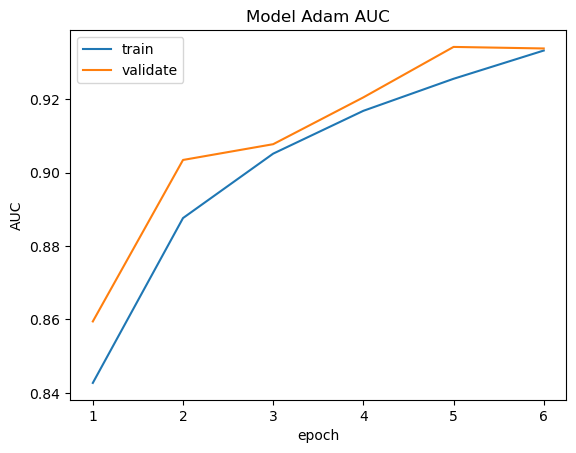

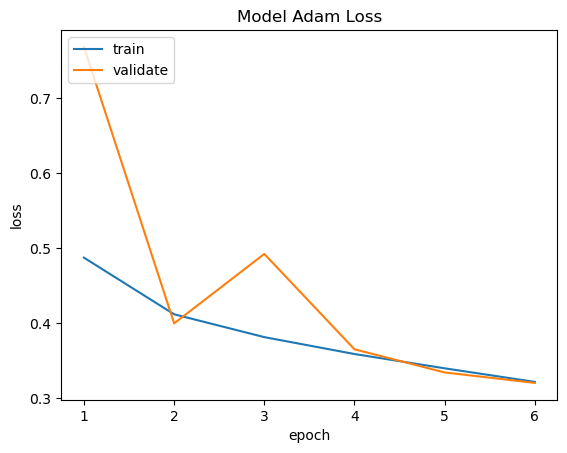

In [37]:

# accuracy plot
plt.plot(np.arange(1,len(history_adam.history['accuracy']) + 1), history_adam.history['accuracy'])
plt.plot(np.arange(1,len(history_adam.history['val_accuracy']) + 1),history_adam.history['val_accuracy'])
plt.title('Model Adam Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# auc plot
plt.plot(np.arange(1,len(history_adam.history['auc_2']) + 1), history_adam.history['auc_2'])
plt.plot(np.arange(1,len(history_adam.history['val_auc_2']) + 1),history_adam.history['val_auc_2'])
plt.title('Model Adam AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# loss plot
plt.plot(np.arange(1,len(history_adam.history['loss']) + 1),history_adam.history['loss'])
plt.plot(np.arange(1,len(history_adam.history['val_loss']) + 1),history_adam.history['val_loss'])
plt.title('Model Adam Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();



Our second model with adam optimization performed much better on validation set. 

### Preparing for Submission
To be able to test our model with the test set we need to submit to kaggle. Our second model performed better so we will use that model to predict on the test data. 

In [38]:
# generate test image data
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test,
    directory= 'test',
    x_col = 'id', 
    y_col = None,
    target_size = (64, 64),         
    batch_size = 1,
    shuffle = False,
    class_mode = None)

Found 57458 validated image filenames.


Predict using our second model, with adam optimization. 

In [43]:
preds_adam = model_adam.predict(test_generator, verbose=1)

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 54s 942us/step


Create a data frame for submission

In [45]:
#create submission dataframe
preds = np.transpose(preds_adam)[0]
submission_adam = pd.DataFrame()
submission_adam['id'] = test['id'].apply(lambda x: x.split('.')[0])
submission_adam['label'] = list(map(lambda x: 0 if x < 0.5 else 1, preds_adam))
submission_adam.head()


,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,0
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0
2,19709bec800f372d0b1d085da6933dd3ef108846,1
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0


In [46]:
submission_adam['label'].value_counts()

label
0    37389
1    20069
Name: count, dtype: int64

In [47]:
submission_adam.to_csv('submission.csv', index=False)

### Results
The kaggle submission resulted in 0.7664 private score and 0.8053 private score. 

## Conclusion
For this project two CNN models were created to classify images of tissue as cancerous or non-cancerous. The second model with adam optimization performed much better, however the real difference might be the learning rate. For the first model the default learning rate was used, which is 0.001. That probably caused the first model to overstep the global minimum. The learning rate used for the second model was 0.0001 and it resulted in better performance.

For future improvements further hyperparameter tuning such as different batch sizes can be performed. Also different architecture choices can be explored. As this kaggle project was adapted from PCam, transfer learning could be employed. 